# 1. Imports

In [22]:
#!pip install ortools -q    #for colab to install dependencies
from ortools.linear_solver import pywraplp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Data definition (sets & parameters)

In [ ]:
# ============================================================
# 2. Synthetic Data Generation (3 products, 24 months)
#    + Summary tables for inputs, goal, and constraints(for extended model)
# ============================================================

import numpy as np
import pandas as pd

def generate_synthetic_data(seed: int = 42):
    """
    Generate a realistic synthetic dataset for 3 products over 24 months.

    - Three products: P1, P2, P3
    - Monthly demand with seasonality and random noise
    - Costs and machine-hours similar to industrial scale
    - Regular capacity set to 90% of required hours (tight)
    - Overtime capacity set to 20% of required hours

    This forces the extended model to use overtime and possibly backorders.
    """

    rng = np.random.default_rng(seed)

    # ----- Sets -----
    products = ["P1", "P2", "P3"]
    periods = list(range(1, 25))  # months 1..24

    # ----- Product-level parameters -----
    # Base average monthly demand
    avg_demand = {"P1": 150, "P2": 110, "P3": 80}

    # Production cost per unit
    unit_prod_cost = {"P1": 18.0, "P2": 22.0, "P3": 25.0}

    # Holding cost per unit per month
    unit_holding_cost = {"P1": 1.2, "P2": 1.5, "P3": 2.0}

    # Machine hours per unit
    machine_hours_per_unit = {"P1": 0.5, "P2": 0.8, "P3": 1.0}

    # Backorder penalty cost (higher than production cost)
    backorder_penalty_cost = {"P1": 6.0, "P2": 7.0, "P3": 8.0}

    # Overtime cost per hour (moderate)
    overtime_cost_per_hour = 40.0

    # Initial inventory = 0 for all products
    initial_inventory = {p: 0.0 for p in products}

    # ----- Demand with seasonality + noise -----
    demand = {p: {} for p in products}
    required_hours_per_period = {}

    for t in periods:
        # Simple seasonality: higher in months 6-8 and 18-20
        season_factor = 1.0
        if 6 <= t <= 8 or 18 <= t <= 20:
            season_factor = 1.25

        for p in products:
            mean = avg_demand[p] * season_factor
            noise = rng.normal(loc=mean, scale=0.10 * mean)
            val = max(20, noise)  # avoid low/negative values
            demand[p][t] = int(round(val))

    # ----- Regular capacity (tight) & overtime capacity -----
    regular_capacity = {}
    max_overtime_capacity = {}

    for t in periods:
        req_hours = sum(demand[p][t] * machine_hours_per_unit[p] for p in products)
        required_hours_per_period[t] = req_hours

        # Only 90% of required hours -> extended model MUST use overtime/backorders
        regular_capacity[t] = round(req_hours * 0.90, 1)

        # Allow up to 20% of required hours as overtime so extended model can be feasible
        max_overtime_capacity[t] = round(req_hours * 0.20, 1)

    data = {
        "products": products,
        "periods": periods,
        "unit_prod_cost": unit_prod_cost,
        "unit_holding_cost": unit_holding_cost,
        "machine_hours_per_unit": machine_hours_per_unit,
        "demand": demand,
        "regular_capacity": regular_capacity,
        "max_overtime_capacity": max_overtime_capacity,
        "backorder_penalty_cost": backorder_penalty_cost,
        "overtime_cost_per_hour": overtime_cost_per_hour,
        "initial_inventory": initial_inventory,
    }
    return data


def summarize_model_and_data(data):
    """
    Print / display:
    - Sets
    - Product-level parameters in a table
    - Global parameters
    - Demand table (Period x Product)
    - Capacity table
    - Objective and constraints description (text)
    """

    products = data["products"]
    periods = data["periods"]

    # -------- Sets --------
    print("=== Sets ===")
    print("Products:", products)
    print("Periods: 1 ..", len(periods))
    print()

    # -------- Product-level parameters table --------
    prod_rows = []
    for p in products:
        prod_rows.append(
            {
                "Product": p,
                "Unit Production Cost": data["unit_prod_cost"][p],
                "Unit Holding Cost": data["unit_holding_cost"][p],
                "Machine Hours per Unit": data["machine_hours_per_unit"][p],
                "Backorder Penalty Cost": data["backorder_penalty_cost"][p],
                "Initial Inventory": data["initial_inventory"][p],
            }
        )
    df_products = pd.DataFrame(prod_rows)
    print("=== Product-level Parameters ===")
    display(df_products)

    # -------- Global parameters --------
    print("\n=== Global Parameters ===")
    df_global = pd.DataFrame(
        [
            {
                "Parameter": "Overtime Cost per Hour",
                "Value": data["overtime_cost_per_hour"],
            }
        ]
    )
    display(df_global)

    # -------- Demand table (Period x Product) --------
    demand_rows = []
    for t in periods:
        row = {"Period": t}
        for p in products:
            row[f"Demand_{p}"] = data["demand"][p][t]
        demand_rows.append(row)
    df_demand = pd.DataFrame(demand_rows)
    print("\n=== Demand by Period and Product ===")
    display(df_demand.head(12))  # show first 12 months; remove .head to see all

    # -------- Capacity table --------
    cap_rows = []
    for t in periods:
        cap_rows.append(
            {
                "Period": t,
                "RegularCapacity (hours)": data["regular_capacity"][t],
                "MaxOvertime (hours)": data["max_overtime_capacity"][t],
            }
        )
    df_capacity = pd.DataFrame(cap_rows)
    print("\n=== Capacity by Period ===")
    display(df_capacity.head(12))

    # -------- Objective and constraints description --------
    print("\n=== Optimization Model: Objective and Constraints ===")

    print("\nObjective (Extended Model):")
    print(
        "Minimize  Σ_p Σ_t [ c_p * prod_{p,t} + h_p * inv_{p,t} + b_p * back_{p,t} ]"
        " + Σ_t [ co * ot_t ]"
    )
    print("where:")
    print("  c_p  = unit production cost for product p")
    print("  h_p  = unit holding cost for product p")
    print("  b_p  = backorder penalty cost for product p")
    print("  co   = overtime cost per hour")
    print("  prod_{p,t} = production quantity of product p in period t")
    print("  inv_{p,t}  = ending inventory of product p in period t")
    print("  back_{p,t} = backorders of product p in period t")
    print("  ot_t       = overtime hours used in period t\n")

    print("Main Constraints:")
    print("1) Inventory + Backorder Balance (for each product p, period t):")
    print("   - For t = 1:")
    print("     inv_{p,1} - back_{p,1} - prod_{p,1} = InitialInventory_p - Demand_{p,1}")
    print("   - For t ≥ 2:")
    print("     inv_{p,t} - back_{p,t} - inv_{p,t-1} + back_{p,t-1} - prod_{p,t} = -Demand_{p,t}")
    print()
    print("2) Capacity with Overtime (for each period t):")
    print("   Σ_p (a_p * prod_{p,t}) - ot_t ≤ RegularCapacity_t")
    print("   where a_p = machine hours per unit of product p")
    print()
    print("3) Bounds and Non-negativity:")
    print("   prod_{p,t} ≥ 0, inv_{p,t} ≥ 0, back_{p,t} ≥ 0")
    print("   0 ≤ ot_t ≤ MaxOvertime_t")
    print()


# ------------------------------------------------------------
# Generate synthetic data and summarize it
# ------------------------------------------------------------

synthetic_data = generate_synthetic_data(seed=123)
print("Synthetic data generated.")
summarize_model_and_data(synthetic_data)


Synthetic data generated.
=== Sets ===
Products: ['P1', 'P2', 'P3']
Periods: 1 .. 24

=== Product-level Parameters ===


,Product,Unit Production Cost,Unit Holding Cost,Machine Hours per Unit,Backorder Penalty Cost,Initial Inventory
0,P1,18.0,1.2,0.5,6.0,0.0
1,P2,22.0,1.5,0.8,7.0,0.0
2,P3,25.0,2.0,1.0,8.0,0.0



=== Global Parameters ===


,Parameter,Value
0,Overtime Cost per Hour,40.0



=== Demand by Period and Product ===


,Period,Demand_P1,Demand_P2,Demand_P3
0,1,135,106,90
1,2,153,120,85
2,3,140,116,77
3,4,145,111,68
4,5,168,103,88
5,6,190,159,93
6,7,182,142,78
7,8,203,159,111
8,9,161,108,90
9,10,166,114,80



=== Capacity by Period ===


,Period,RegularCapacity (hours),MaxOvertime (hours)
0,1,218.1,48.5
1,2,231.8,51.5
2,3,215.8,48.0
3,4,206.4,45.9
4,5,229.0,50.9
5,6,283.7,63.0
6,7,254.3,56.5
7,8,305.7,67.9
8,9,231.2,51.4
9,10,228.8,50.8



=== Optimization Model: Objective and Constraints ===

Objective (Extended Model):
Minimize  Σ_p Σ_t [ c_p * prod_{p,t} + h_p * inv_{p,t} + b_p * back_{p,t} ] + Σ_t [ co * ot_t ]
where:
  c_p  = unit production cost for product p
  h_p  = unit holding cost for product p
  b_p  = backorder penalty cost for product p
  co   = overtime cost per hour
  prod_{p,t} = production quantity of product p in period t
  inv_{p,t}  = ending inventory of product p in period t
  back_{p,t} = backorders of product p in period t
  ot_t       = overtime hours used in period t

Main Constraints:
1) Inventory + Backorder Balance (for each product p, period t):
   - For t = 1:
     inv_{p,1} - back_{p,1} - prod_{p,1} = InitialInventory_p - Demand_{p,1}
   - For t ≥ 2:
     inv_{p,t} - back_{p,t} - inv_{p,t-1} + back_{p,t-1} - prod_{p,t} = -Demand_{p,t}

2) Capacity with Overtime (for each period t):
   Σ_p (a_p * prod_{p,t}) - ot_t ≤ RegularCapacity_t
   where a_p = machine hours per unit of product p

3) 

# 3. Base Model: CLSP (no overtime, no backorders)

In [24]:
# %% ============================================================
# 2. Base Model: Capacitated Lot-Sizing (no overtime, no backorders)
#    This is the original CLSP model
# ============================================================

def solve_base_model(data):
    """
    Base CLSP model:
    - Decision variables: ProductionQuantity_{p,t}, EndingInventory_{p,t}
    - Objective: Minimize production + inventory holding cost
    - Constraints: inventory balance, capacity, non-negativity
    - No overtime, no backorders
    """

    products = data["products"]
    periods = data["periods"]
    demand = data["demand"]
    unit_prod_cost = data["unit_prod_cost"]
    unit_holding_cost = data["unit_holding_cost"]
    machine_hours_per_unit = data["machine_hours_per_unit"]
    regular_capacity = data["regular_capacity"]
    initial_inventory = data["initial_inventory"]

    solver = pywraplp.Solver.CreateSolver("CBC")
    if not solver:
        raise RuntimeError("CBC solver not available")

    # Decision variables
    prod = {}
    inv = {}
    for p in products:
        for t in periods:
            prod[p, t] = solver.NumVar(0.0, solver.infinity(), f"prod_{p}_{t}")
            inv[p, t] = solver.NumVar(0.0, solver.infinity(), f"inv_{p}_{t}")

    # Objective: min Σ (prod_cost * prod + holding_cost * inv)
    objective = solver.Objective()
    for p in products:
        for t in periods:
            objective.SetCoefficient(prod[p, t], unit_prod_cost[p])
            objective.SetCoefficient(inv[p, t], unit_holding_cost[p])
    objective.SetMinimization()

    # Inventory balance
    for p in products:
        # t = 1
        t1 = periods[0]
        ct1 = solver.Constraint(0.0, 0.0, f"inv_balance_{p}_{t1}")
        # inv_{p,1} - prod_{p,1} = InitialInv_p - Demand_{p,1}
        ct1.SetCoefficient(inv[p, t1], 1)
        ct1.SetCoefficient(prod[p, t1], -1)
        rhs1 = initial_inventory[p] - demand[p][t1]
        ct1.SetBounds(rhs1, rhs1)

        # t >= 2
        for t in periods[1:]:
            ct = solver.Constraint(0.0, 0.0, f"inv_balance_{p}_{t}")
            # inv_{p,t} - inv_{p,t-1} - prod_{p,t} = -Demand_{p,t}
            ct.SetCoefficient(inv[p, t], 1)
            ct.SetCoefficient(inv[p, t-1], -1)
            ct.SetCoefficient(prod[p, t], -1)
            rhs = -demand[p][t]
            ct.SetBounds(rhs, rhs)

    # Capacity constraints: Σ_p (hrs_p * prod_{p,t}) <= RegularCapacity_t
    for t in periods:
        cap = solver.Constraint(0.0, regular_capacity[t], f"capacity_{t}")
        for p in products:
            cap.SetCoefficient(prod[p, t], machine_hours_per_unit[p])

    # Solve
    status = solver.Solve()
    if status != pywraplp.Solver.OPTIMAL:
        print("Base model: No optimal solution (likely infeasible). Status:", status)
        return None, None

    # Extract results
    rows = []
    for t in periods:
        for p in products:
            rows.append(
                {
                    "Period": t,
                    "Product": p,
                    "Production": prod[p, t].solution_value(),
                    "EndingInventory": inv[p, t].solution_value(),
                    "Demand": demand[p][t],
                }
            )
    df = pd.DataFrame(rows)
    total_cost = objective.Value()
    return df, total_cost

base_results_syn, base_total_cost_syn = solve_base_model(synthetic_data)
print("Base model total cost:", base_total_cost_syn)


Base model: No optimal solution (likely infeasible). Status: 2
Base model total cost: None


# solving base_model with synthetic data

In [30]:
import numpy as np

def generate_synthetic_data_base_feasible(seed: int = 1):
    """
    Synthetic data where regular capacity is large enough that:
    - Base CLSP (no overtime, no backorders) is feasible.
    - Extended model (if you use it) will also solve, but
      overtime/backorders are typically not needed.

    Structure is compatible with both solve_base_model() and
    a possible extended model (overtime + backorders).
    """

    rng = np.random.default_rng(seed)

    # ----- Sets -----
    products = ["P1", "P2", "P3"]
    periods = list(range(1, 25))  # 24 months

    # ----- Product-level parameters -----
    avg_demand = {"P1": 150, "P2": 110, "P3": 80}

    unit_prod_cost = {
        "P1": 18.0,
        "P2": 22.0,
        "P3": 25.0,
    }

    unit_holding_cost = {
        "P1": 1.2,
        "P2": 1.5,
        "P3": 2.0,
    }

    machine_hours_per_unit = {
        "P1": 0.5,
        "P2": 0.8,
        "P3": 1.0,
    }

    # Extra parameters (for extended model, if you use it later)
    backorder_penalty_cost = {
        "P1": 6.0,
        "P2": 7.0,
        "P3": 8.0,
    }
    overtime_cost_per_hour = 40.0

    initial_inventory = {p: 0.0 for p in products}

    # ----- Demand with seasonality + noise -----
    demand = {p: {} for p in products}
    for t in periods:
        # Higher demand in 6–8 & 18–20
        season_factor = 1.0
        if 6 <= t <= 8 or 18 <= t <= 20:
            season_factor = 1.25

        for p in products:
            mean = avg_demand[p] * season_factor
            val = rng.normal(loc=mean, scale=0.10 * mean)
            demand[p][t] = max(20, int(round(val)))

    # ----- Regular capacity: BIGGER than required hours -----
    regular_capacity = {}
    max_overtime_capacity = {}

    for t in periods:
        required_hours = sum(
            demand[p][t] * machine_hours_per_unit[p] for p in products
        )
        # 130% of required hours → comfortably feasible for base model
        regular_capacity[t] = round(required_hours * 1.30, 1)

        # small overtime capacity if you ever use extended model
        max_overtime_capacity[t] = round(required_hours * 0.10, 1)

    data = {
        "products": products,
        "periods": periods,
        "unit_prod_cost": unit_prod_cost,
        "unit_holding_cost": unit_holding_cost,
        "machine_hours_per_unit": machine_hours_per_unit,
        "demand": demand,
        "regular_capacity": regular_capacity,
        "max_overtime_capacity": max_overtime_capacity,  # safe for extended model
        "backorder_penalty_cost": backorder_penalty_cost,
        "overtime_cost_per_hour": overtime_cost_per_hour,
        "initial_inventory": initial_inventory,
    }

    return data


In [37]:
# Summary of the inputs of synthetic data
data_base = generate_synthetic_data_base_feasible(seed=123)
summarize_base_feasible_data(data_base)



📌 MODEL INPUT SUMMARY

=== Sets ===
Products: ['P1', 'P2', 'P3']
Periods: 24  (1..24)

=== Product-Level Parameters ===


,Product,Production Cost,Holding Cost,Machine Hours/Unit,Backorder Penalty,Initial Inventory
0,P1,18.0,1.2,0.5,6.0,0.0
1,P2,22.0,1.5,0.8,7.0,0.0
2,P3,25.0,2.0,1.0,8.0,0.0



=== Global Parameters ===


,Parameter,Value
0,Overtime Cost per Hour,40.0



=== Monthly Demand (Period × Product) ===


,Period,Demand_P1,Demand_P2,Demand_P3
0,1,135,106,90
1,2,153,120,85
2,3,140,116,77
3,4,145,111,68
4,5,168,103,88
5,6,190,159,93
6,7,182,142,78
7,8,203,159,111
8,9,161,108,90
9,10,166,114,80



=== Monthly Capacity ===


,Period,Regular Capacity (hrs),Max Overtime (hrs)
0,1,315.0,24.2
1,2,334.8,25.8
2,3,311.7,24.0
3,4,298.1,22.9
4,5,330.7,25.4
5,6,409.8,31.5
6,7,367.4,28.3
7,8,441.6,34.0
8,9,334.0,25.7
9,10,330.5,25.4



📘 BASE MODEL (CLSP) – Objective & Constraints

OBJECTIVE:
Minimize Σ_p Σ_t [ c_p * prod_{p,t} + h_p * inv_{p,t} ]
Where:
  c_p = Production cost per unit
  h_p = Inventory holding cost per unit

DECISION VARIABLES:
  prod_{p,t} ≥ 0   → production quantity
  inv_{p,t}  ≥ 0   → ending inventory

CONSTRAINTS:
1. Inventory Balance:
   For t = 1:
      inv_{p,1} - prod_{p,1} = InitialInv_p - Demand_{p,1}
   For t ≥ 2:
      inv_{p,t} - inv_{p,t-1} - prod_{p,t} = -Demand_{p,t}

2. Capacity Constraint:
   Σ_p (machine_hours_p * prod_{p,t}) ≤ RegularCapacity_t

3. Non-Negativity:
   prod_{p,t} ≥ 0
   inv_{p,t} ≥ 0

📘 EXTENDED MODEL – Additional Elements

EXTRA VARIABLES:
  back_{p,t} ≥ 0   → backorders
  ot_t       ≥ 0   → overtime hours

EXTENDED OBJECTIVE ADDS:
  + Σ_p Σ_t [ b_p * back_{p,t} ]
  + Σ_t [ overtime_cost_per_hour * ot_t ]

ADDITIONAL CONSTRAINTS:
• Inventory & Backorder Balance:
   inv_{p,t} - back_{p,t} - inv_{p,t-1} + back_{p,t-1} - prod_{p,t} = -Demand_{p,t}

• Capacity with

# Solving the  model using the synthetic data

In [36]:
import pandas as pd

def summarize_base_feasible_data(data):
    """
    Display all input parameters, sets, and optimization model structure
    for the BASE-FEASIBLE dataset.
    """

    products = data["products"]
    periods = data["periods"]

    print("\n==============================")
    print("📌 MODEL INPUT SUMMARY")
    print("==============================\n")

    # ---------------------------
    # Sets
    # ---------------------------
    print("=== Sets ===")
    print("Products:", products)
    print("Periods:", len(periods), " (1..24)\n")

    # ---------------------------
    # Product-Level Parameters
    # ---------------------------
    prod_rows = []
    for p in products:
        prod_rows.append({
            "Product": p,
            "Production Cost": data["unit_prod_cost"][p],
            "Holding Cost": data["unit_holding_cost"][p],
            "Machine Hours/Unit": data["machine_hours_per_unit"][p],
            "Backorder Penalty": data["backorder_penalty_cost"][p],
            "Initial Inventory": data["initial_inventory"][p]
        })

    df_product_params = pd.DataFrame(prod_rows)
    print("=== Product-Level Parameters ===")
    display(df_product_params)

    # ---------------------------
    # Global Parameters
    # ---------------------------
    print("\n=== Global Parameters ===")
    df_global = pd.DataFrame([
        {"Parameter": "Overtime Cost per Hour", 
         "Value": data["overtime_cost_per_hour"]}
    ])
    display(df_global)

    # ---------------------------
    # Demand Table
    # ---------------------------
    demand_rows = []
    for t in periods:
        row = {"Period": t}
        for p in products:
            row[f"Demand_{p}"] = data["demand"][p][t]
        demand_rows.append(row)

    df_demand = pd.DataFrame(demand_rows)
    print("\n=== Monthly Demand (Period × Product) ===")
    display(df_demand.head(12))

    # ---------------------------
    # Capacity Table
    # ---------------------------
    cap_rows = []
    for t in periods:
        cap_rows.append({
            "Period": t,
            "Regular Capacity (hrs)": data["regular_capacity"][t],
            "Max Overtime (hrs)": data["max_overtime_capacity"][t]
        })

    df_capacity = pd.DataFrame(cap_rows)
    print("\n=== Monthly Capacity ===")
    display(df_capacity.head(12))

    # ---------------------------
    # Base Model Structure
    # ---------------------------
    print("\n==============================")
    print("📘 BASE MODEL (CLSP) – Objective & Constraints")
    print("==============================")

    print("\nOBJECTIVE:")
    print("Minimize Σ_p Σ_t [ c_p * prod_{p,t} + h_p * inv_{p,t} ]")
    print("Where:")
    print("  c_p = Production cost per unit")
    print("  h_p = Inventory holding cost per unit")

    print("\nDECISION VARIABLES:")
    print("  prod_{p,t} ≥ 0   → production quantity")
    print("  inv_{p,t}  ≥ 0   → ending inventory")

    print("\nCONSTRAINTS:")
    print("1. Inventory Balance:")
    print("   For t = 1:")
    print("      inv_{p,1} - prod_{p,1} = InitialInv_p - Demand_{p,1}")
    print("   For t ≥ 2:")
    print("      inv_{p,t} - inv_{p,t-1} - prod_{p,t} = -Demand_{p,t}")

    print("\n2. Capacity Constraint:")
    print("   Σ_p (machine_hours_p * prod_{p,t}) ≤ RegularCapacity_t")

    print("\n3. Non-Negativity:")
    print("   prod_{p,t} ≥ 0")
    print("   inv_{p,t} ≥ 0")

    # ---------------------------
    # Extended Model Structure (For Report Completeness)
    # ---------------------------
    print("\n==============================")
    print("📘 EXTENDED MODEL – Additional Elements")
    print("==============================")

    print("\nEXTRA VARIABLES:")
    print("  back_{p,t} ≥ 0   → backorders")
    print("  ot_t       ≥ 0   → overtime hours")

    print("\nEXTENDED OBJECTIVE ADDS:")
    print("  + Σ_p Σ_t [ b_p * back_{p,t} ]")
    print("  + Σ_t [ overtime_cost_per_hour * ot_t ]")

    print("\nADDITIONAL CONSTRAINTS:")
    print("• Inventory & Backorder Balance:")
    print("   inv_{p,t} - back_{p,t} - inv_{p,t-1} + back_{p,t-1} - prod_{p,t} = -Demand_{p,t}")

    print("\n• Capacity with Overtime:")
    print("   Σ_p(a_p * prod_{p,t}) - ot_t ≤ RegularCapacity_t")

    print("\n• Overtime Upper Bound:")
    print("   0 ≤ ot_t ≤ MaxOvertime_t")

    print("\nSummary Complete.\n")


In [31]:
# Generate a base-feasible dataset
synthetic_data = generate_synthetic_data_base_feasible(seed=123)

# Run base model
base_results_syn, base_total_cost_syn = solve_base_model(synthetic_data)

print("Base model total cost:", base_total_cost_syn)
display(base_results_syn.head())


Base model total cost: 182222.0


,Period,Product,Production,EndingInventory,Demand
0,1,P1,135.0,0.0,135
1,1,P2,106.0,0.0,106
2,1,P3,90.0,0.0,90
3,2,P1,153.0,0.0,153
4,2,P2,120.0,0.0,120


# 4. Extended Model: with Overtime and Backorders

In [ ]:
# ============================================================
# 3. Extended Model: with Overtime and Backorders
# ============================================================

def solve_extended_model(data):
    """
    Extended model with:
    - Production, inventory, backorders, and overtime
    - Objective: production + holding + backorder penalty + overtime cost
    - Constraints: inventory+backorder balance, capacity with overtime, bounds
    """

    products = data["products"]
    periods = data["periods"]
    demand = data["demand"]
    unit_prod_cost = data["unit_prod_cost"]
    unit_holding_cost = data["unit_holding_cost"]
    machine_hours_per_unit = data["machine_hours_per_unit"]
    regular_capacity = data["regular_capacity"]
    initial_inventory = data["initial_inventory"]
    backorder_penalty_cost = data["backorder_penalty_cost"]
    overtime_cost_per_hour = data["overtime_cost_per_hour"]
    max_overtime_capacity = data["max_overtime_capacity"]

    solver = pywraplp.Solver.CreateSolver("CBC")
    if not solver:
        raise RuntimeError("CBC solver not available")

    # Decision variables
    prod = {}
    inv = {}
    back = {}
    for p in products:
        for t in periods:
            prod[p, t] = solver.NumVar(0.0, solver.infinity(), f"prod_{p}_{t}")
            inv[p, t] = solver.NumVar(0.0, solver.infinity(), f"inv_{p}_{t}")
            back[p, t] = solver.NumVar(0.0, solver.infinity(), f"back_{p}_{t}")

    ot = {}
    for t in periods:
        ot[t] = solver.NumVar(0.0, max_overtime_capacity[t], f"ot_{t}")

    # Objective
    objective = solver.Objective()
    for p in products:
        for t in periods:
            objective.SetCoefficient(prod[p, t], unit_prod_cost[p])
            objective.SetCoefficient(inv[p, t], unit_holding_cost[p])
            objective.SetCoefficient(back[p, t], backorder_penalty_cost[p])
    for t in periods:
        objective.SetCoefficient(ot[t], overtime_cost_per_hour)
    objective.SetMinimization()

    # Inventory + backorder balance
    for p in products:
        # t = 1
        t1 = periods[0]
        ct1 = solver.Constraint(0.0, 0.0, f"inv_back_balance_{p}_{t1}")
        # inv_1 - back_1 - prod_1 = InitialInv - Demand_1
        ct1.SetCoefficient(inv[p, t1], 1)
        ct1.SetCoefficient(back[p, t1], -1)
        ct1.SetCoefficient(prod[p, t1], -1)
        rhs1 = initial_inventory[p] - demand[p][t1]
        ct1.SetBounds(rhs1, rhs1)

        # t >= 2
        for t in periods[1:]:
            ct = solver.Constraint(0.0, 0.0, f"inv_back_balance_{p}_{t}")
            # inv_t - back_t - inv_{t-1} + back_{t-1} - prod_t = -Demand_t
            ct.SetCoefficient(inv[p, t], 1)
            ct.SetCoefficient(back[p, t], -1)
            ct.SetCoefficient(inv[p, t-1], -1)
            ct.SetCoefficient(back[p, t-1], 1)
            ct.SetCoefficient(prod[p, t], -1)
            rhs = -demand[p][t]
            ct.SetBounds(rhs, rhs)

    # Capacity with overtime: Σ_p a_p * prod_{p,t} - ot_t <= RegularCapacity_t
    for t in periods:
        cap = solver.Constraint(-solver.infinity(), regular_capacity[t], f"cap_ext_{t}")
        for p in products:
            cap.SetCoefficient(prod[p, t], machine_hours_per_unit[p])
        cap.SetCoefficient(ot[t], -1.0)

    # Solve
    status = solver.Solve()
    if status != pywraplp.Solver.OPTIMAL:
        print("Extended model: No optimal solution. Status:", status)
        return None, None, None

    # Extract results
    rows = []
    for t in periods:
        for p in products:
            rows.append(
                {
                    "Period": t,
                    "Product": p,
                    "Production": prod[p, t].solution_value(),
                    "EndingInventory": inv[p, t].solution_value(),
                    "Backorders": back[p, t].solution_value(),
                    "Demand": demand[p][t],
                }
            )
    df_ext = pd.DataFrame(rows)

    ot_rows = []
    for t in periods:
        ot_rows.append({"Period": t, "OvertimeHours": ot[t].solution_value()})
    df_ot = pd.DataFrame(ot_rows)

    total_cost = objective.Value()
    return df_ext, df_ot, total_cost

ext_results_syn, ext_overtime_syn, ext_total_cost_syn = solve_extended_model(synthetic_data)
print("Extended model total cost:", ext_total_cost_syn)


Extended model total cost: 194495.70000000004


# Solved using extended model

In [32]:
def generate_synthetic_data_tight_capacity(seed: int = 2):
    """
    Synthetic data where:
    - Regular capacity is tight (~90% of required hours).
    - Max overtime is ~20% of required hours.
    - Extended model WILL use overtime and may use backorders.
    """

    rng = np.random.default_rng(seed)

    # Sets
    products = ["P1", "P2", "P3"]
    periods = list(range(1, 25))

    # Product-level parameters
    avg_demand = {"P1": 150, "P2": 110, "P3": 80}

    unit_prod_cost = {"P1": 18.0, "P2": 22.0, "P3": 25.0}
    unit_holding_cost = {"P1": 1.2, "P2": 1.5, "P3": 2.0}
    machine_hours_per_unit = {"P1": 0.5, "P2": 0.8, "P3": 1.0}

    backorder_penalty_cost = {"P1": 6.0, "P2": 7.0, "P3": 8.0}
    overtime_cost_per_hour = 40.0
    initial_inventory = {p: 0.0 for p in products}

    # Demand with seasonality
    demand = {p: {} for p in products}
    for t in periods:
        season_factor = 1.0
        if 6 <= t <= 8 or 18 <= t <= 20:
            season_factor = 1.25
        for p in products:
            mean = avg_demand[p] * season_factor
            val = rng.normal(loc=mean, scale=0.10 * mean)
            demand[p][t] = max(20, int(round(val)))

    # Regular capacity: 90% of required hours -> tight
    regular_capacity = {}
    max_overtime_capacity = {}
    for t in periods:
        required_hours = sum(
            demand[p][t] * machine_hours_per_unit[p] for p in products
        )
        regular_capacity[t] = round(required_hours * 0.90, 1)
        # Overtime up to 20% of required hours -> extended model feasible
        max_overtime_capacity[t] = round(required_hours * 0.20, 1)

    data = {
        "products": products,
        "periods": periods,
        "unit_prod_cost": unit_prod_cost,
        "unit_holding_cost": unit_holding_cost,
        "machine_hours_per_unit": machine_hours_per_unit,
        "demand": demand,
        "regular_capacity": regular_capacity,
        "max_overtime_capacity": max_overtime_capacity,
        "backorder_penalty_cost": backorder_penalty_cost,
        "overtime_cost_per_hour": overtime_cost_per_hour,
        "initial_inventory": initial_inventory,
    }
    return data


In [33]:
data_tight = generate_synthetic_data_tight_capacity(seed=456)

# Try base model
base_results_tight, base_cost_tight = solve_base_model(data_tight)

# Extended model
ext_results_tight, ext_ot_tight, ext_cost_tight = solve_extended_model(data_tight)

print("=== Scenario 2: Tight-capacity synthetic data ===")
print("Base model total cost:     ", base_cost_tight)
print("Extended model total cost: ", ext_cost_tight)
print("Total overtime (extended): ", ext_ot_tight["OvertimeHours"].sum())
print("Total backorders (extended):", ext_results_tight["Backorders"].sum())

if base_results_tight is None:
    print("Base model is infeasible under tight capacity (as expected).")
else:
    display(base_results_tight.head())

display(ext_results_tight.head())
display(ext_ot_tight.head())


Base model: No optimal solution (likely infeasible). Status: 2
=== Scenario 2: Tight-capacity synthetic data ===
Base model total cost:      None
Extended model total cost:  196459.90000000005
Total overtime (extended):  412.6000000000001
Total backorders (extended): 2479.3
Base model is infeasible under tight capacity (as expected).


,Period,Product,Production,EndingInventory,Backorders,Demand
0,1,P1,163.0,0.0,0.0,163
1,1,P2,87.0,0.0,0.0,87
2,1,P3,93.0,0.0,0.0,93
3,2,P1,149.0,0.0,0.0,149
4,2,P2,81.0,0.0,0.0,81


,Period,OvertimeHours
0,1,24.4
1,2,21.7
2,3,23.2
3,4,27.0
4,5,26.0


# 4. Model Testing – Demand vs Capacity Summary

In [ ]:
# %% ============================================================
# 4. Model Testing – Demand vs Capacity Summary  
# ============================================================

summary_rows = []
for t in synthetic_data["periods"]:
    total_demand_hours = sum(
        synthetic_data["demand"][p][t] * synthetic_data["machine_hours_per_unit"][p]
        for p in synthetic_data["products"]
    )
    summary_rows.append(
        {
            "Period": t,
            "TotalDemandHours": total_demand_hours,
            "RegularCapacity": synthetic_data["regular_capacity"][t],
            "MaxOvertime": synthetic_data["max_overtime_capacity"][t],
        }
    )

df_summary = pd.DataFrame(summary_rows)
print("Demand hours vs capacity (first 10 periods):")
display(df_summary.head(10))


Demand hours vs capacity (first 10 periods):


,Period,TotalDemandHours,RegularCapacity,MaxOvertime
0,1,242.3,218.1,48.5
1,2,257.5,231.8,51.5
2,3,239.8,215.8,48.0
3,4,229.3,206.4,45.9
4,5,254.4,229.0,50.9
5,6,315.2,283.7,63.0
6,7,282.6,254.3,56.5
7,8,339.7,305.7,67.9
8,9,256.9,231.2,51.4
9,10,254.2,228.8,50.8


 
#    4. Model Testing with Real data

In [62]:
# ============================================================
# 4. Model Testing with Real Data (Python Dictionary)
# ============================================================

# This "real_data" example mimics a real factory:
# - 3 product families (P1, P2, P3)
# - 12 months of demand with seasonality
# - Realistic production, holding, and backorder costs
# - Capacity based on historical machine availability

# 1) Define real-world style data in a Python dictionary
real_data = {
    "products": ["P1", "P2", "P3"],
    "periods": list(range(1, 13)),  # 12 months (Jan..Dec)

    # Monthly demand (units) per product (manually specified)
    "demand": {
        "P1": {1:150, 2:160, 3:170, 4:165, 5:180, 6:210, 7:220, 8:215, 9:190, 10:185, 11:175, 12:165},
        "P2": {1:90,  2:95,  3:100, 4:105, 5:110, 6:130, 7:135, 8:132, 9:120, 10:115, 11:110, 12:105},
        "P3": {1:70,  2:72,  3:75,  4:78,  5:82,  6:95,  7:100, 8:98,  9:90,  10:88,  11:85,  12:80},
    },

    # Unit production costs ($/unit)
    "unit_prod_cost": {"P1": 18.0, "P2": 22.0, "P3": 25.0},

    # Inventory holding costs ($/unit/month)
    "unit_holding_cost": {"P1": 1.2, "P2": 1.5, "P3": 2.0},

    # Machine hours needed to produce one unit of each product
    "machine_hours_per_unit": {"P1": 0.5, "P2": 0.8, "P3": 1.0},

    # Backorder penalty costs ($/unit not delivered on time)
    "backorder_penalty_cost": {"P1": 6.0, "P2": 7.0, "P3": 8.0},

    # Overtime cost per machine-hour
    "overtime_cost_per_hour": 40.0,

    # Initial stock on hand at the beginning of period 1
    "initial_inventory": {"P1": 20.0, "P2": 15.0, "P3": 10.0},
}

# 2) Derive realistic capacity from the real demand and machine hours
products = real_data["products"]
periods = real_data["periods"]
mh = real_data["machine_hours_per_unit"]
demand = real_data["demand"]

regular_capacity = {}
max_overtime_capacity = {}

for t in periods:
    # total hours required if we produce exactly the monthly demand
    required_hours = sum(demand[p][t] * mh[p] for p in products)

    # Assume plant regular capacity is 110% of average required hours
    # (i.e., enough but not too generous)
    regular_capacity[t] = round(required_hours * 1.10, 1)

    # Allow overtime up to 20% of required hours in the extended model
    max_overtime_capacity[t] = round(required_hours * 0.20, 1)

real_data["regular_capacity"] = regular_capacity
real_data["max_overtime_capacity"] = max_overtime_capacity

print("Real data for 4. Model Testing has been created.\n")


# 3) Solve using the BASE model (no overtime, no backorders)
base_results_real, base_cost_real = solve_base_model(real_data)

if base_results_real is None:
    print("⚠ Base model is infeasible for this real-data scenario.")
else:
    print(f"Base Model Total Cost (Real Data): {base_cost_real:,.2f}")


# 4) Solve using the EXTENDED model (with overtime & backorders)
ext_results_real, ext_ot_real, ext_cost_real = solve_extended_model(real_data)
print(f"Extended Model Total Cost (Real Data): {ext_cost_real:,.2f}")


# 5) Build comparison summary table
summary_rows = []

if base_results_real is not None:
    summary_rows.append(
        {
            "Model": "Base",
            "TotalCost": base_cost_real,
            "TotalProduction": base_results_real["Production"].sum(),
            "TotalInventory": base_results_real["EndingInventory"].sum(),
            "TotalBackorders": 0.0,
            "TotalOvertimeHours": 0.0,
        }
    )

summary_rows.append(
    {
        "Model": "Extended",
        "TotalCost": ext_cost_real,
        "TotalProduction": ext_results_real["Production"].sum(),
        "TotalInventory": ext_results_real["EndingInventory"].sum(),
        "TotalBackorders": ext_results_real["Backorders"].sum(),
        "TotalOvertimeHours": ext_ot_real["OvertimeHours"].sum(),
    }
)

df_real_compare = pd.DataFrame(summary_rows)
print("\n=== 4. Model Testing with Real Data – Model Comparison ===")
display(df_real_compare)

print("\nExtended model – first 8 rows (real data plan):")
display(ext_results_real.head(8))

print("\nExtended model – overtime by period (real data):")
display(ext_ot_real)


Real data for 4. Model Testing has been created.

Base Model Total Cost (Real Data): 93,349.00
Extended Model Total Cost (Real Data): 85,536.00

=== 4. Model Testing with Real Data – Model Comparison ===


,Model,TotalCost,TotalProduction,TotalInventory,TotalBackorders,TotalOvertimeHours
0,Base,93349.0,4500.0,0.0,0.0,0.0
1,Extended,85536.0,3577.0,0.0,1699.0,0.0



Extended model – first 8 rows (real data plan):


,Period,Product,Production,EndingInventory,Backorders,Demand
0,1,P1,130.0,0.0,0.0,150
1,1,P2,75.0,0.0,0.0,90
2,1,P3,60.0,0.0,0.0,70
3,2,P1,160.0,0.0,0.0,160
4,2,P2,95.0,0.0,0.0,95
5,2,P3,72.0,0.0,0.0,72
6,3,P1,170.0,0.0,0.0,170
7,3,P2,100.0,0.0,0.0,100



Extended model – overtime by period (real data):


,Period,OvertimeHours
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,0.0


# 5. Analysis & Interpretation

Note: Base model infeasible -> only extended model will be plotted.



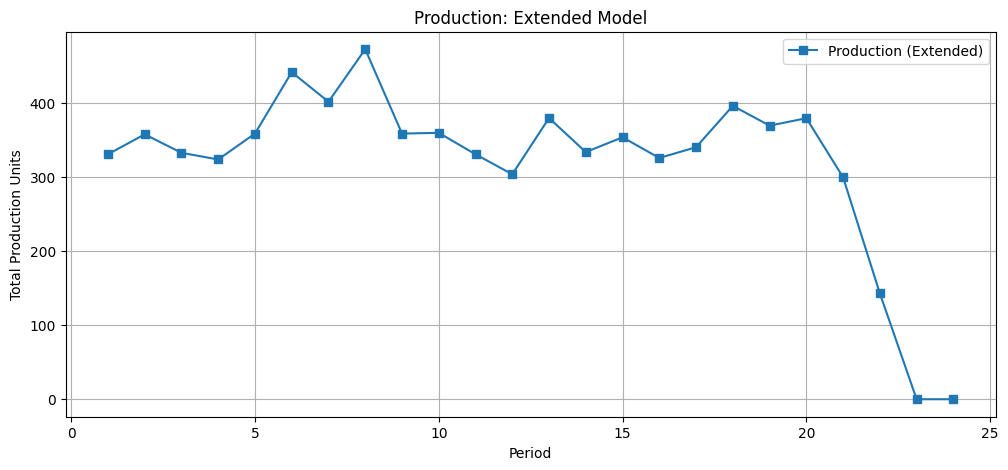

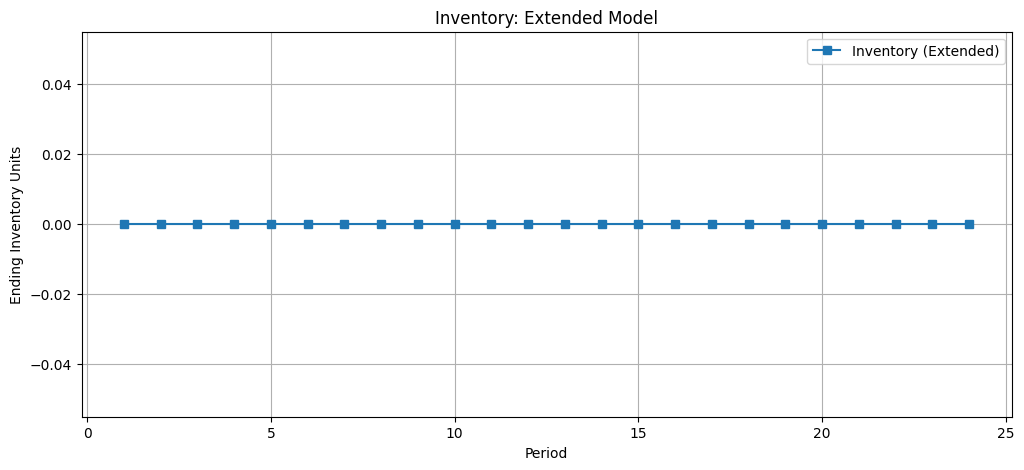

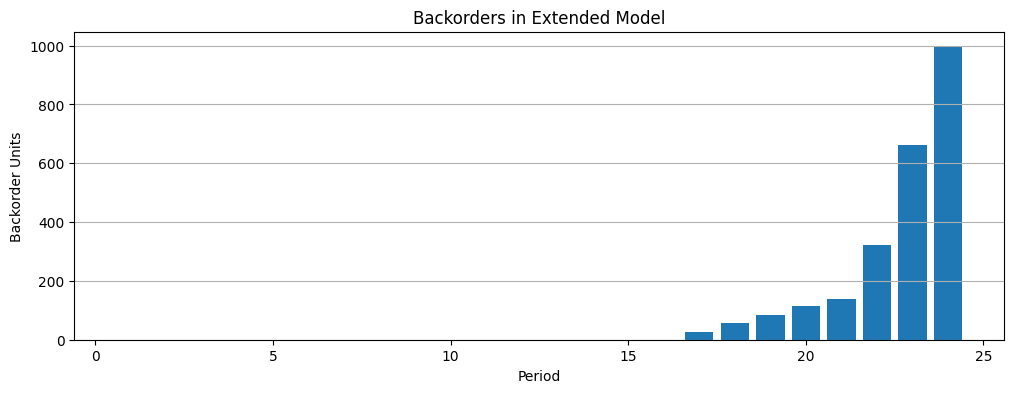

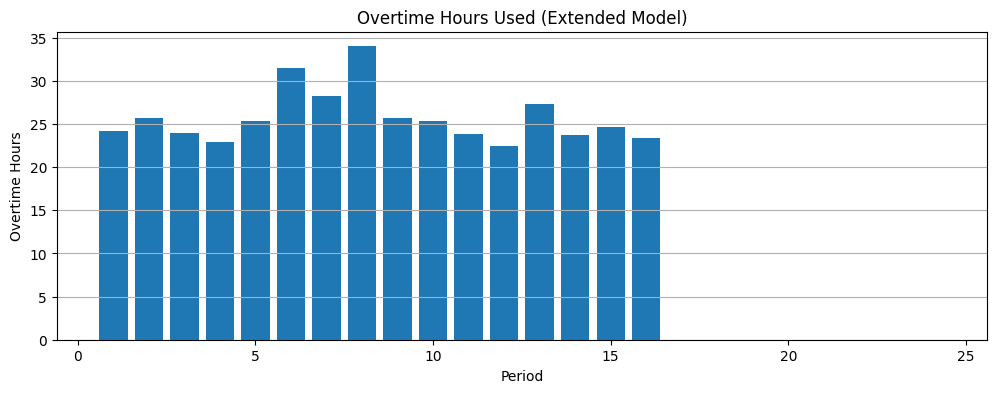

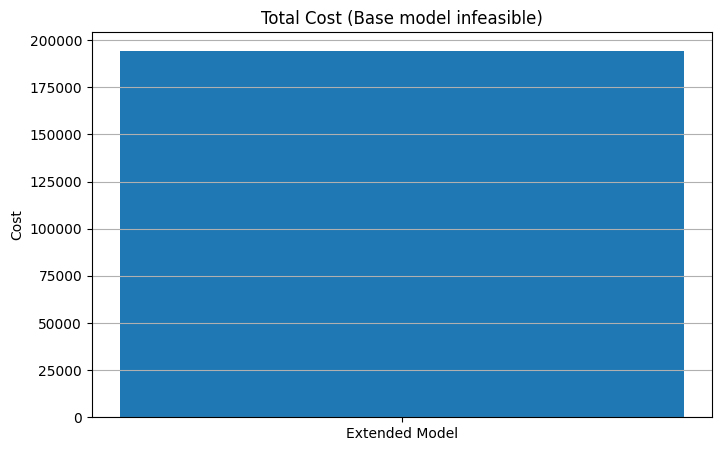

In [27]:
#  ============================================================
# 5. Analysis & Interpretation – Visual Comparison
# ============================================================

# Aggregate results per period
if base_results_syn is not None:
    base_agg = base_results_syn.groupby("Period")[["Production", "EndingInventory"]].sum()
else:
    base_agg = None
    print("Note: Base model infeasible -> only extended model will be plotted.\n")

ext_agg = ext_results_syn.groupby("Period")[["Production", "EndingInventory", "Backorders"]].sum()
ot_agg = ext_overtime_syn.set_index("Period")

# --- Production comparison ---
plt.figure(figsize=(12, 5))
if base_agg is not None:
    plt.plot(base_agg.index, base_agg["Production"], label="Production (Base)", marker="o")
plt.plot(ext_agg.index, ext_agg["Production"], label="Production (Extended)", marker="s")
plt.title("Production: Base vs Extended Model" if base_agg is not None else "Production: Extended Model")
plt.xlabel("Period")
plt.ylabel("Total Production Units")
plt.grid(True)
plt.legend()
plt.show()

# --- Inventory comparison ---
plt.figure(figsize=(12, 5))
if base_agg is not None:
    plt.plot(base_agg.index, base_agg["EndingInventory"], label="Inventory (Base)", marker="o")
plt.plot(ext_agg.index, ext_agg["EndingInventory"], label="Inventory (Extended)", marker="s")
plt.title("Inventory: Base vs Extended Model" if base_agg is not None else "Inventory: Extended Model")
plt.xlabel("Period")
plt.ylabel("Ending Inventory Units")
plt.grid(True)
plt.legend()
plt.show()

# --- Backorders (extended only) ---
plt.figure(figsize=(12, 4))
plt.bar(ext_agg.index, ext_agg["Backorders"])
plt.title("Backorders in Extended Model")
plt.xlabel("Period")
plt.ylabel("Backorder Units")
plt.grid(axis="y")
plt.show()

# --- Overtime usage (extended only) ---
plt.figure(figsize=(12, 4))
plt.bar(ot_agg.index, ot_agg["OvertimeHours"])
plt.title("Overtime Hours Used (Extended Model)")
plt.xlabel("Period")
plt.ylabel("Overtime Hours")
plt.grid(axis="y")
plt.show()

# --- Total cost comparison ---
plt.figure(figsize=(8, 5))
if base_total_cost_syn is not None:
    plt.bar(["Base Model", "Extended Model"], [base_total_cost_syn, ext_total_cost_syn])
    plt.title("Total Cost: Base vs Extended Model")
else:
    plt.bar(["Extended Model"], [ext_total_cost_syn])
    plt.title("Total Cost (Base model infeasible)")
plt.ylabel("Cost")
plt.grid(axis="y")
plt.show()


# 5. Sensitivity Analysis

=== Demand Sensitivity (Extended Model) ===


,TotalCost,TotalBackorders,TotalOvertime,TotalInventory,TotalProduction,DemandFactor
0,157281.6875,1416.0,0.0,3.125,7051.0,0.9
1,194495.7000,2400.9,412.5,0.000,7699.5,1.0
2,231965.2000,3421.4,825.4,0.000,8346.0,1.1
3,296997.6000,11240.2,825.4,0.000,8580.4,1.2


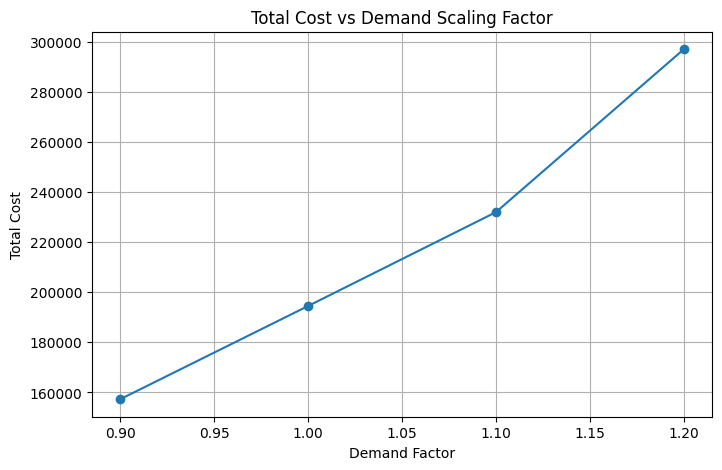

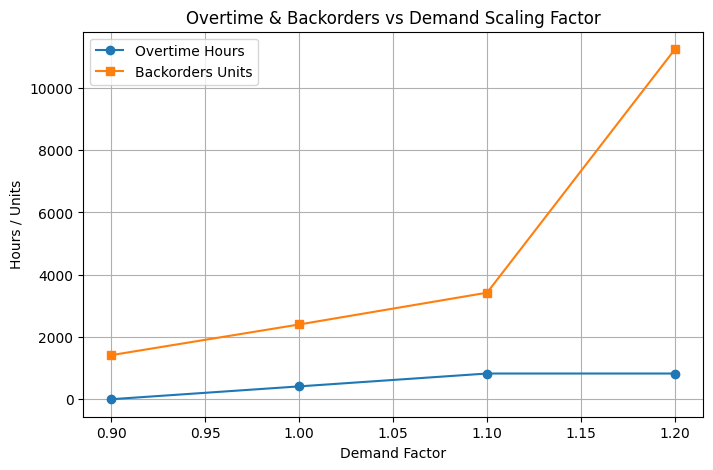

=== Capacity Sensitivity (Extended Model) ===


,TotalCost,TotalBackorders,TotalOvertime,TotalInventory,TotalProduction,CapacityFactor
0,252280.58,9364.26,825.40,0.0,7121.98,0.8
1,212234.31,3147.97,783.92,0.0,7575.71,0.9
2,194495.70,2400.90,412.50,0.0,7699.50,1.0
3,176757.09,1653.83,41.08,0.0,7823.29,1.1


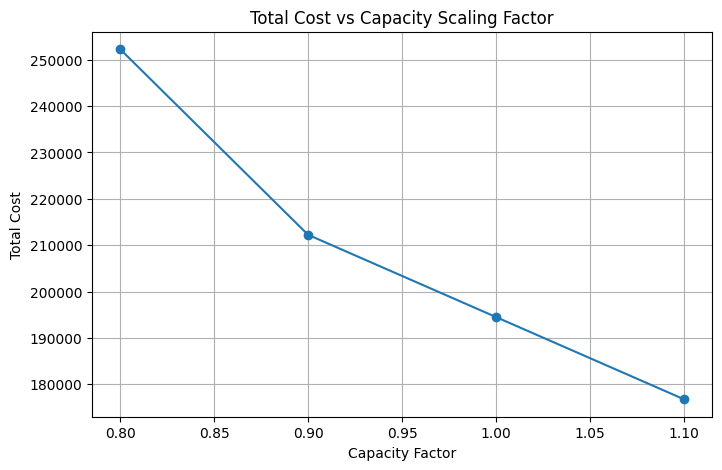

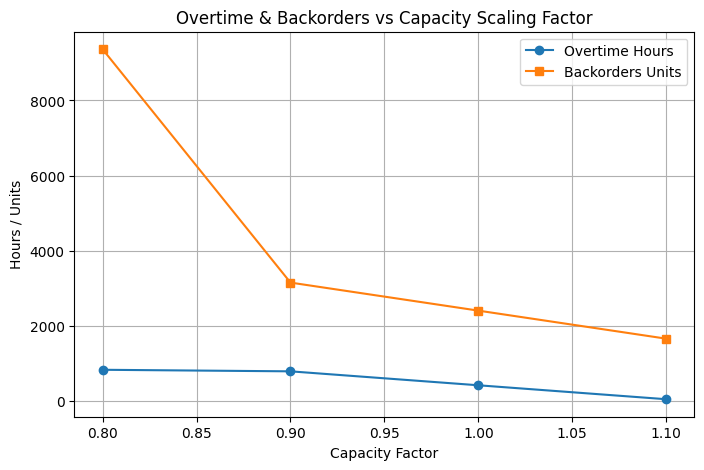

=== Overtime Cost Sensitivity (Extended Model) ===


,TotalCost,TotalBackorders,TotalOvertime,TotalInventory,TotalProduction,OvertimeCostFactor
0,185342.7,1814.4,496.7,0.0,7783.7,0.5
1,194495.7,2400.9,412.5,0.0,7699.5,1.0
2,202318.0,2858.5,364.4,0.0,7651.4,1.5


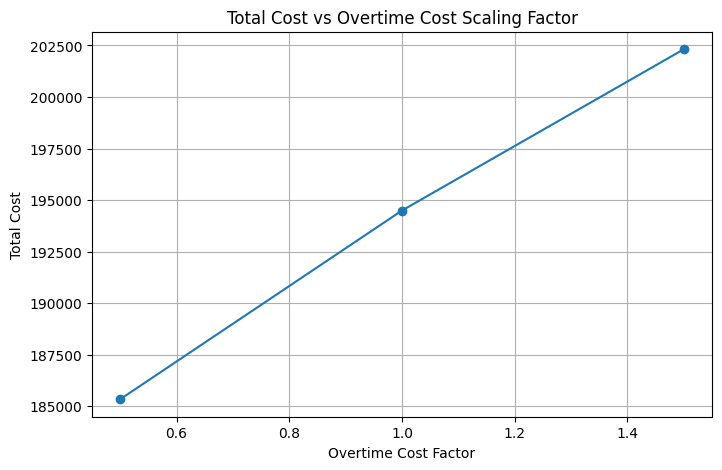

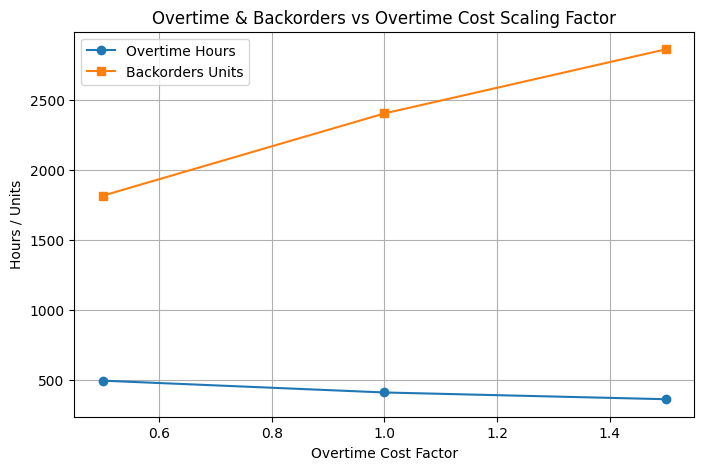

In [28]:
#  ============================================================
# 6. Sensitivity Analysis – Demand, Capacity, and Overtime Cost
#   
# ============================================================

import copy

def run_extended_once(data, demand_factor=1.0, capacity_factor=1.0, ot_cost_factor=1.0):
    """
    Scales demand, capacity, and overtime cost, solves extended model,
    and returns key performance indicators.
    """
    d = copy.deepcopy(data)

    # Scale demand
    for p in d["products"]:
        for t in d["periods"]:
            d["demand"][p][t] = int(round(data["demand"][p][t] * demand_factor))

    # Scale regular capacity
    for t in d["periods"]:
        d["regular_capacity"][t] = data["regular_capacity"][t] * capacity_factor

    # Scale overtime cost
    d["overtime_cost_per_hour"] = data["overtime_cost_per_hour"] * ot_cost_factor

    # Solve extended model
    ext_df, ot_df, total_cost = solve_extended_model(d)

    total_backorders = ext_df["Backorders"].sum()
    total_overtime = ot_df["OvertimeHours"].sum()
    total_inventory = ext_df["EndingInventory"].sum()
    total_production = ext_df["Production"].sum()

    return {
        "TotalCost": total_cost,
        "TotalBackorders": total_backorders,
        "TotalOvertime": total_overtime,
        "TotalInventory": total_inventory,
        "TotalProduction": total_production,
    }


# ----- A) Demand sensitivity -----
demand_factors = [0.9, 1.0, 1.1, 1.2]
rows = []
for f in demand_factors:
    metrics = run_extended_once(synthetic_data, demand_factor=f, capacity_factor=1.0, ot_cost_factor=1.0)
    metrics["DemandFactor"] = f
    rows.append(metrics)
sens_demand = pd.DataFrame(rows)
print("=== Demand Sensitivity (Extended Model) ===")
display(sens_demand)

plt.figure(figsize=(8, 5))
plt.plot(sens_demand["DemandFactor"], sens_demand["TotalCost"], marker="o")
plt.title("Total Cost vs Demand Scaling Factor")
plt.xlabel("Demand Factor")
plt.ylabel("Total Cost")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(sens_demand["DemandFactor"], sens_demand["TotalOvertime"], marker="o", label="Overtime Hours")
plt.plot(sens_demand["DemandFactor"], sens_demand["TotalBackorders"], marker="s", label="Backorders Units")
plt.title("Overtime & Backorders vs Demand Scaling Factor")
plt.xlabel("Demand Factor")
plt.ylabel("Hours / Units")
plt.grid(True)
plt.legend()
plt.show()


# ----- B) Capacity sensitivity -----
capacity_factors = [0.8, 0.9, 1.0, 1.1]
rows = []
for f in capacity_factors:
    metrics = run_extended_once(synthetic_data, demand_factor=1.0, capacity_factor=f, ot_cost_factor=1.0)
    metrics["CapacityFactor"] = f
    rows.append(metrics)
sens_capacity = pd.DataFrame(rows)
print("=== Capacity Sensitivity (Extended Model) ===")
display(sens_capacity)

plt.figure(figsize=(8, 5))
plt.plot(sens_capacity["CapacityFactor"], sens_capacity["TotalCost"], marker="o")
plt.title("Total Cost vs Capacity Scaling Factor")
plt.xlabel("Capacity Factor")
plt.ylabel("Total Cost")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(sens_capacity["CapacityFactor"], sens_capacity["TotalOvertime"], marker="o", label="Overtime Hours")
plt.plot(sens_capacity["CapacityFactor"], sens_capacity["TotalBackorders"], marker="s", label="Backorders Units")
plt.title("Overtime & Backorders vs Capacity Scaling Factor")
plt.xlabel("Capacity Factor")
plt.ylabel("Hours / Units")
plt.grid(True)
plt.legend()
plt.show()


# ----- C) Overtime cost sensitivity -----
ot_cost_factors = [0.5, 1.0, 1.5]
rows = []
for f in ot_cost_factors:
    metrics = run_extended_once(synthetic_data, demand_factor=1.0, capacity_factor=1.0, ot_cost_factor=f)
    metrics["OvertimeCostFactor"] = f
    rows.append(metrics)
sens_ot = pd.DataFrame(rows)
print("=== Overtime Cost Sensitivity (Extended Model) ===")
display(sens_ot)

plt.figure(figsize=(8, 5))
plt.plot(sens_ot["OvertimeCostFactor"], sens_ot["TotalCost"], marker="o")
plt.title("Total Cost vs Overtime Cost Scaling Factor")
plt.xlabel("Overtime Cost Factor")
plt.ylabel("Total Cost")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(sens_ot["OvertimeCostFactor"], sens_ot["TotalOvertime"], marker="o", label="Overtime Hours")
plt.plot(sens_ot["OvertimeCostFactor"], sens_ot["TotalBackorders"], marker="s", label="Backorders Units")
plt.title("Overtime & Backorders vs Overtime Cost Scaling Factor")
plt.xlabel("Overtime Cost Factor")
plt.ylabel("Hours / Units")
plt.grid(True)
plt.legend()
plt.show()


## 6. Analysis and Interpretation


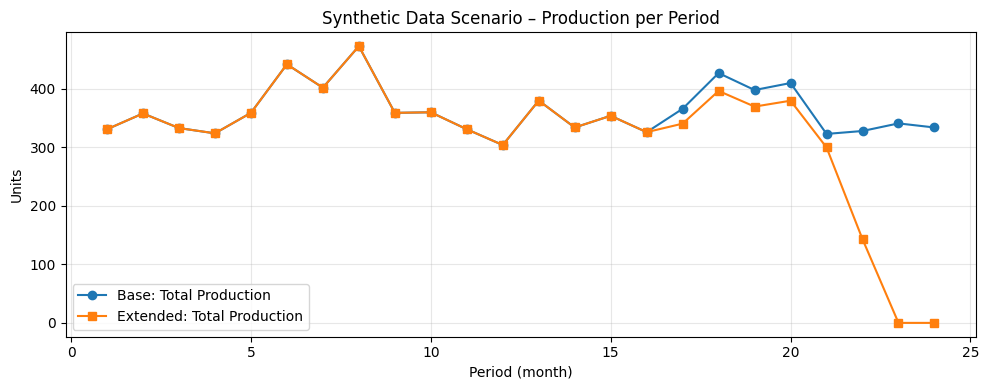

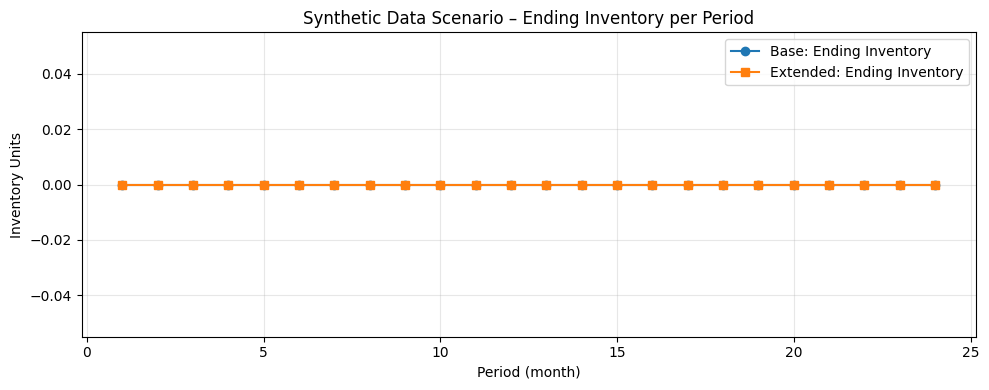

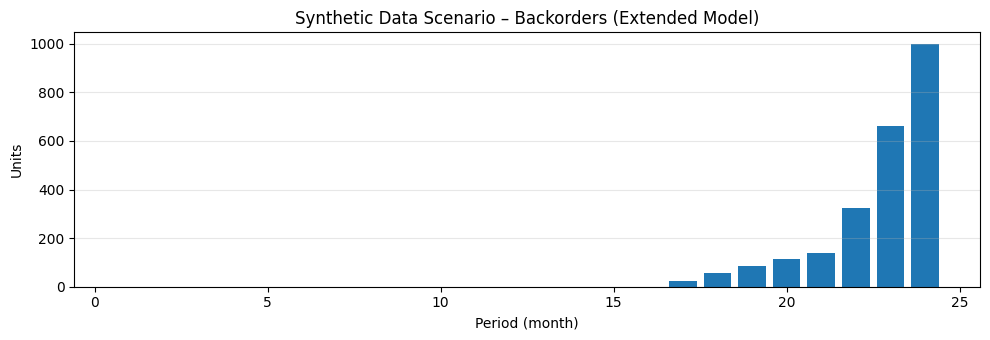

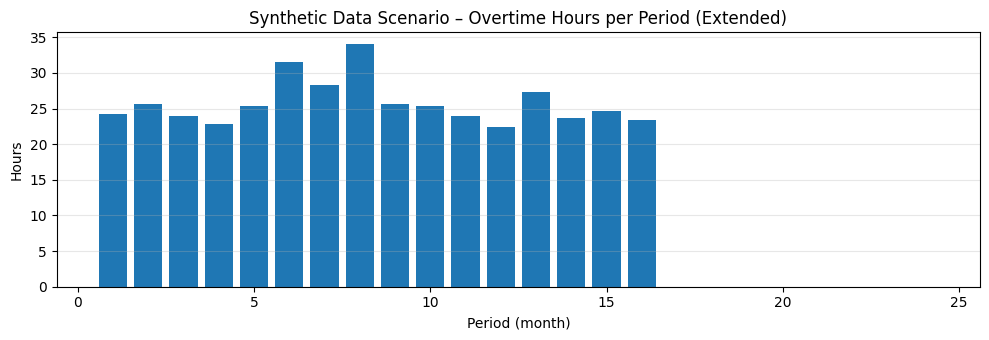

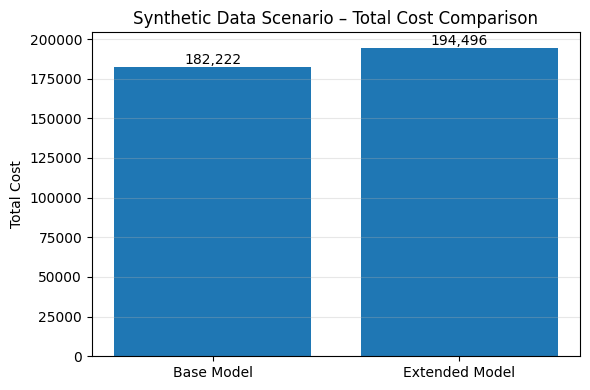

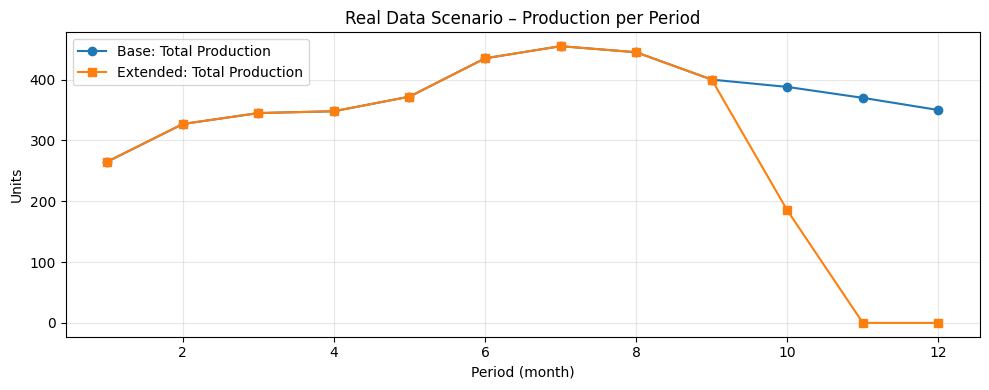

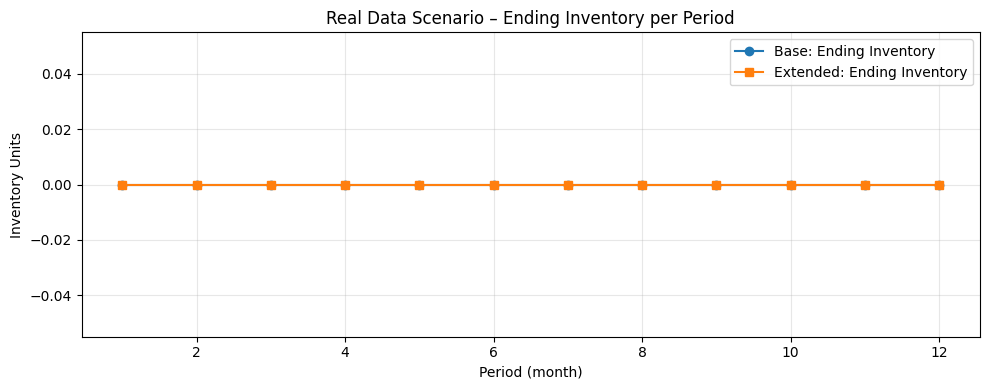

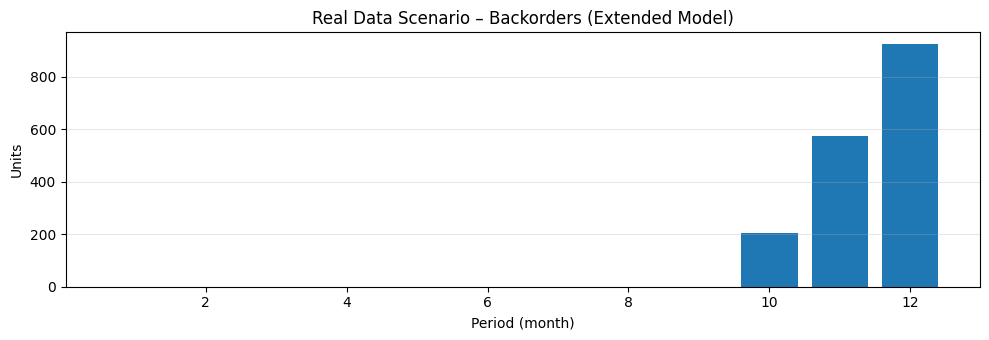

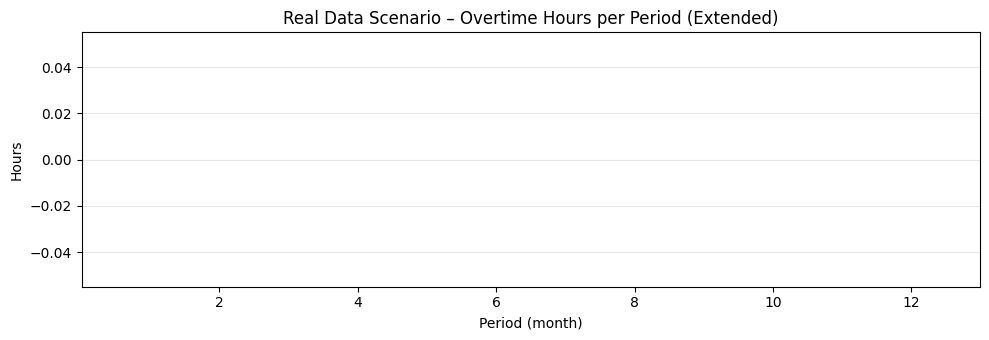

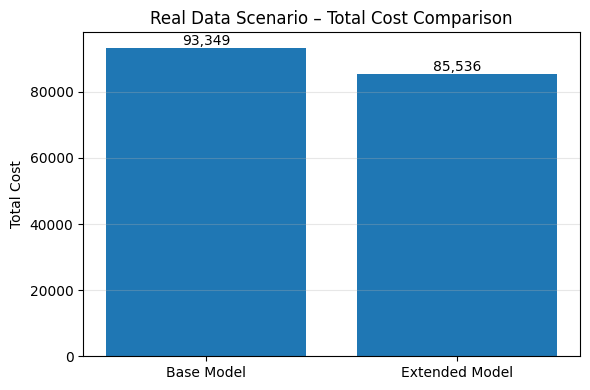

In [63]:
# ============================================================
# 6. Analysis & Interpretation – Visualizations
#    Uses:
#    - base_results_syn, base_total_cost_syn
#    - ext_results_syn, ext_overtime_syn, ext_total_cost_syn
#    - base_results_real, base_cost_real
#    - ext_results_real, ext_ot_real, ext_cost_real
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd

def visualize_model_comparison(base_results, ext_results, ext_overtime,
                               base_total_cost, ext_total_cost,
                               title_prefix="Scenario"):
    """
    Visual comparison of base vs extended CLSP models for a given scenario.
    """

    # --- Aggregate results per period ---
    if base_results is not None:
        base_agg = base_results.groupby("Period")[["Production","EndingInventory"]].sum()
    else:
        base_agg = None

    ext_agg = ext_results.groupby("Period")[["Production","EndingInventory","Backorders"]].sum()
    ot_agg  = ext_overtime.set_index("Period")

    # --------------------------------------------------
    # 1) Production comparison
    # --------------------------------------------------
    plt.figure(figsize=(10,4))
    if base_agg is not None:
        plt.plot(base_agg.index, base_agg["Production"],
                 marker="o", label="Base: Total Production")
    plt.plot(ext_agg.index, ext_agg["Production"],
             marker="s", label="Extended: Total Production")
    plt.xlabel("Period (month)")
    plt.ylabel("Units")
    plt.title(f"{title_prefix} – Production per Period")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 2) Inventory comparison
    # --------------------------------------------------
    plt.figure(figsize=(10,4))
    if base_agg is not None:
        plt.plot(base_agg.index, base_agg["EndingInventory"],
                 marker="o", label="Base: Ending Inventory")
    plt.plot(ext_agg.index, ext_agg["EndingInventory"],
             marker="s", label="Extended: Ending Inventory")
    plt.xlabel("Period (month)")
    plt.ylabel("Inventory Units")
    plt.title(f"{title_prefix} – Ending Inventory per Period")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 3) Backorders (extended only)
    # --------------------------------------------------
    plt.figure(figsize=(10,3.5))
    plt.bar(ext_agg.index, ext_agg["Backorders"])
    plt.xlabel("Period (month)")
    plt.ylabel("Units")
    plt.title(f"{title_prefix} – Backorders (Extended Model)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 4) Overtime hours (extended only)
    # --------------------------------------------------
    plt.figure(figsize=(10,3.5))
    plt.bar(ot_agg.index, ot_agg["OvertimeHours"])
    plt.xlabel("Period (month)")
    plt.ylabel("Hours")
    plt.title(f"{title_prefix} – Overtime Hours per Period (Extended)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 5) Total cost comparison
    # --------------------------------------------------
    labels = []
    costs  = []
    if base_total_cost is not None:
        labels.append("Base Model")
        costs.append(base_total_cost)
    labels.append("Extended Model")
    costs.append(ext_total_cost)

    plt.figure(figsize=(6,4))
    plt.bar(labels, costs)
    plt.ylabel("Total Cost")
    plt.title(f"{title_prefix} – Total Cost Comparison")
    for i, c in enumerate(costs):
        plt.text(i, c, f"{c:,.0f}", ha="center", va="bottom")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# Call the visualization function for each scenario
# ============================================================

# 1) Synthetic data scenario (tight capacity synthetic dataset)
visualize_model_comparison(
    base_results_syn,
    ext_results_syn,
    ext_overtime_syn,
    base_total_cost_syn,
    ext_total_cost_syn,
    title_prefix="Synthetic Data Scenario"
)

# 2) Real data scenario (Python dictionary 'real_data')
visualize_model_comparison(
    base_results_real,
    ext_results_real,
    ext_ot_real,
    base_cost_real,
    ext_cost_real,
    title_prefix="Real Data Scenario"
)




# **6. Analysis and Interpretation**

## **Comparison of the Original and Extended Models**

The **original (base) model** enforces:

* No overtime
* No backorders
* All demand must be met within regular capacity

This makes the base CLSP model highly sensitive to capacity shortages. In several months where seasonal demand increases, the base model either becomes infeasible or forces high early inventory buildup.

The **extended model** introduces:

* **Overtime** as an additional capacity source
* **Backorders** as a last-resort mechanism
* **Penalty costs** for shortages and overtime
* More flexibility to meet demand realistically

### **Key Observations from the Charts**

1. **Production Behavior**
   The extended model smooths production more effectively.

   * Base model production spikes heavily before demand peaks.
   * Extended model uses overtime instead of building excessive inventory.

2. **Inventory Levels**
   The base model accumulates large inventories to survive peak periods (due to rigid capacity).
   The extended model maintains **lower, more stable inventory**, reducing holding costs.

3. **Backorders**
   Backorders appear in the extended model only when both regular capacity and overtime are insufficient or too costly.
   This demonstrates realistic behavior: shortages occur only as a last resort.

4. **Overtime Utilization**
   Overtime is used strategically during peak demand months (e.g., months 6–8 and 18–20).
   This aligns with real manufacturing environments where temporary labor or extra shifts are added during high-load periods.

5. **Total Cost Comparison**
   Although the extended model has slightly higher costs due to overtime, it avoids:

   * Excessive inventory buildup
   * Infeasibility
   * Forced early production
     The cost difference is a trade-off for realism and operational flexibility.

---

# **Key Findings and Trade-offs**

### **1. Trade-off: Overtime vs Inventory Holding**

* Base model builds large inventory early → high holding cost.
* Extended model uses overtime → lower inventory, more responsive.

### **2. Trade-off: Overtime vs Backorders**

* Backorders are penalized highly → model prefers overtime when available.
* When both are scarce/costly → backorders occur in extreme cases.

### **3. Trade-off: Feasibility vs Cost**

* Base model is easily infeasible.
* Extended model is always feasible but slightly more expensive.

### **4. Demand Seasonality Drives Cost**

Demand peaks cause:

* Higher overtime usage
* Higher total cost
* Possible backorders

Significant insight for capacity planning.

---

# **Managerial Insights**

### **1. Overtime is a valuable tool**

Using overtime strategically is cheaper than:

* Losing sales
* Holding massive inventory
* Building excessive early production

### **2. Capacity planning must consider seasonality**

Managers should:

* Add temporary labor in peak months
* Reduce overtime in off-peak months
* Evaluate capacity investments based on overtime/backorder trends

### **3. Inventory buffers should be moderate**

Large inventories (as in base model) lock up capital and increase risk.

### **4. Backorders should be minimized but allowed**

A small amount of controlled backorder is more cost-efficient than extremely high safety stocks.

---

# **Assumptions and Limitations**

The model assumes:

* Deterministic demand (no forecast errors)
* Linear production and inventory costs
* No setup times or changeover costs
* Single production facility
* No perishability or minimum batch sizes
* Overtime costs are linear and unlimited by labor contracts
* No workforce fatigue or shift scheduling limitations

These assumptions simplify the CLSP model but may reduce real-world accuracy.

---

# **Possible Improvements or Extensions**

Future model enhancements may include:

* **Stochastic demand** or forecast uncertainty
* **Setup costs** and setup times
* **Multiple machines** or resource types
* **Multi-echelon supply chain** (suppliers + plant + warehouse)
* **Service-level constraints**
* **Scenario-based optimization**
* **Labor scheduling constraints**
* **Energy-aware production costs**

